# Import Libraries

In [1]:
import os
from os import listdir
from os.path import isfile, join, exists
from sklearn.model_selection import train_test_split
from skimage.feature import daisy,hog
from skimage import io
from skimage.color import rgb2gray
import skimage
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from random import randint

from tqdm import tqdm
from sklearn.metrics import accuracy_score

import numpy as np
from sklearn import svm

import sklearn.cluster
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Data Import

In [2]:
directory = "Dataset1/"
categories_name = os.listdir(directory)

# Categories for Classifications

In [3]:
categories_name

['abbey',
 'access_road',
 'airplane_cabin',
 'airport_terminal',
 'alcove',
 'art_gallery',
 'art_studio',
 'atrium',
 'attic',
 'casino',
 'castle',
 'childs_room',
 'corridor',
 'creek',
 'crosswalk']

In [4]:
def file_path(path):
    file = [path+f for f in listdir(path) if isfile(join(path, f))]
    return file

# Label to every category

In [5]:
labels=[]
file = []
for cat in categories_name:
    files  = file_path(directory + cat +"/")
    for f in files:
        file.append(f)
        labels.append(categories_name.index(cat))
    

# Randomly splitting images

In [6]:
train_files,test_files,train_labels,test_labels=train_test_split(file,labels,test_size=0.4,random_state=40)


In [7]:
len(train_files)

446

In [8]:
len(test_files)

298

# Extracting HOG Descriptors

In [9]:
def extract_hog_descriptors(image,hog_pixels_per_cell=16,hog_cells_per_block=1):
   
    hog_descriptor=hog(image, orientations=8, pixels_per_cell=(hog_pixels_per_cell, hog_pixels_per_cell),cells_per_block=(hog_cells_per_block, hog_cells_per_block), visualise = False,feature_vector=True)
    
    hog_descriptor = hog_descriptor.reshape(len(hog_descriptor),1)
    return hog_descriptor

# Extracting Daisy Descriptors

In [10]:
def extract_daisy_descriptors(image,daisy_step_size=32,daisy_radius=32):
        d = daisy(image, step=daisy_step_size, radius=daisy_radius, rings=2, histograms=8,orientations=8, visualize=False)
        num_of_descriptor = d.shape[0] * d.shape[1]
        daisy_desriptors=d.reshape(num_of_descriptor,d.shape[2])
        return daisy_desriptors

# Construction of HOG and Daisy Descriptors

In [11]:
hog_descriptor_list = []
daisy_descriptor_list = []
HOG_AND_DAISY_FEATURES = {}
for file_path in tqdm(train_files):
   
    image = io.imread(file_path)
    image_gray = rgb2gray(image)
    
    image=skimage.transform.resize(image_gray,(700,700))
    #plt.imshow(image)
    #plt.show()
    hog_descriptor = extract_hog_descriptors(image)
    daisy_descriptor = extract_daisy_descriptors(image, daisy_step_size=8,daisy_radius=8)
    HOG_AND_DAISY_FEATURES[file_path] = [hog_descriptor,daisy_descriptor]
    hog_descriptor_list =  hog_descriptor_list + list(hog_descriptor)
    daisy_descriptor_list = daisy_descriptor_list + list(daisy_descriptor)
    

  0%|                                                                                          | 0/446 [00:00<?, ?it/s]C:\Users\MOHIT\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\MOHIT\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|████████████████████████████████████████████████████████████████████████████████| 446/446 [16:19<00:00,  2.32s/it]


In [12]:
len(daisy_descriptor_list)

3298616

# Function of Clustring - Mini Batch K means with batch of 10000

In [13]:
def clustering(daisy_descriptor,number_of_clusters):
    #km=KMeans(n_clusters=number_of_clusters)
    km=MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=number_of_clusters*1)
    km.fit(daisy_descriptor)
    return km

In [14]:
cluster_model = clustering(daisy_descriptor,1000)

In [15]:
cluster_model

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=1000, n_init=3, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)

# Hybrid Daisy and HOG 

In [16]:
def hybrid_descriptor(file, cluster_model):
    
    if file in HOG_AND_DAISY_FEATURES:
        daisy_feature = HOG_AND_DAISY_FEATURES[file][1]
        hog_feature = HOG_AND_DAISY_FEATURES[file][0]
    else:
        image = io.imread(file)
        image_gray = rgb2gray(image)

        image=skimage.transform.resize(image_gray,(700,700))
        hog_feature = extract_hog_descriptors(image)
        daisy_feature = extract_daisy_descriptors(image, daisy_step_size=8,daisy_radius=8)
        #HOG_AND_DAISY_FEATURES[file_path] = [file,daisy_feature]
        #hog_descriptor_list =  hog_descriptor_list + list(hog_feature)
        #daisy_descriptor_list = daisy_descriptor_list + list(daisy_feature)
        
    image_cluster_prediction = cluster_model.predict(daisy_feature)
    cluster_freq_counts=pd.DataFrame(image_cluster_prediction,columns=['cnt'])['cnt'].value_counts()
    bovw_vector=np.zeros(cluster_model.n_clusters)
    #print(len(image_cluster_prediction))
    #print(len(cluster_freq_counts))
    #bovw_vector=np.zeros(daisy_cluster_model.n_clusters)
    for key in cluster_freq_counts.keys():
        bovw_vector[key]=cluster_freq_counts[key]

    bovw_feature=bovw_vector/np.linalg.norm(bovw_vector)
    hog_feature=hog_feature/np.linalg.norm(hog_feature)
    
    return list(bovw_feature)+list(hog_feature)

In [17]:
len(train_labels)

446

# Data Training

In [18]:
X_train = []
Y_train = []
i = 0;
for file in train_files:
    X_train.append(hybrid_descriptor(file, cluster_model))
    Y_train.append(train_labels[i])
    i = i + 1

# Linear SVM

In [19]:
hc = svm.LinearSVC()
hc.fit(X_train, Y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

# Kernel SVM

In [20]:
hybrid_classifier=svm.SVC(C=10**1.6794140624999994, gamma=10**-0.1630955304365928, decision_function_shape='ovo') #cross-validated hyper-parameters
hybrid_classifier.fit(X_train,Y_train)

SVC(C=47.798477392518556, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=0.6869173242795459,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# Function for Plotting image

In [21]:
def plot(fname):
    img=plt.imread(fname)
    image_gray = rgb2gray(img)
    plt.imshow(image_gray, cmap='Greys_r')

# Prection of label

actual label 12


C:\Users\MOHIT\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\MOHIT\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


prediction: [12]


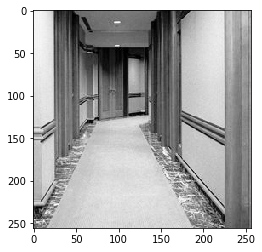

In [22]:
i =randint(0, 298)
plot(test_files[i])
print("actual label",test_labels[i])
hybrid_feature_vector=hybrid_descriptor(test_files[i],cluster_model)
print ('prediction:',hybrid_classifier.predict([hybrid_feature_vector]))


# Testing Data

In [23]:
X_Test = []
Y_Test = []
i = 0
for file in test_files:
    X_Test.append(hybrid_descriptor(file, cluster_model))
    Y_Test.append(test_labels[i])
    i = i + 1

C:\Users\MOHIT\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\MOHIT\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [24]:
len(hog_descriptor_list)

6597232

In [25]:
hybridpred1 = hybrid_classifier.predict(X_Test)
hybridpred2 = hc.predict(X_Test)

In [26]:
print ('Overall accuracy:',accuracy_score(Y_Test,hybridpred1))


Overall accuracy: 0.48322147651006714


In [27]:
print ('Overall accuracy:',accuracy_score(Y_Test,hybridpred2))


Overall accuracy: 0.5369127516778524


In [31]:
XTRAIN_HOG=[]
for X in X_train:
    XTRAIN_HOG.append(X[cluster_model.n_clusters:])

In [34]:
XTEST_HOG=[]
for X in X_Test:
    XTEST_HOG.append(X[cluster_model.n_clusters:])

In [37]:
hogclassifier=svm.LinearSVC()
hogclassifier.fit(XTRAIN_HOG,Y_train)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
print ('HOG Only Classifier Mertics')
print ('No. of test instances:',len(XTEST_HOG),len(YTEST))
### Accuracy Report ###
pred=hogclassifier.predict(XTEST_HOG)
print( 'Overall accuracy:',accuracy_score(YTEST,pred))